<a href="https://www.kaggle.com/code/averma111/pytorch-cafa-5-prediction?scriptVersionId=131056622" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
%%capture 
!pip install torchmetrics

In [2]:
%%capture
!pip install torchsummary

In [3]:
## https://www.kaggle.com/code/alexandervc/baseline-multilabel-to-multitarget-binary#Load-train-features---precalculated-embeddings-for-the-proteins
import os
import gc
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
tqdm.pandas()
import torch
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchmetrics import AUROC,F1Score
from torchmetrics.classification import BinaryF1Score
from torchsummary import summary as torchsummary


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def get_dataframe(path):
    return pd.read_csv(path,sep='\t')

In [5]:
train_terms = '/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv'
train_taxonomy ='/kaggle/input/cafa-5-protein-function-prediction/Train/train_taxonomy.tsv'

In [6]:
get_dataframe(train_terms).head()

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


In [7]:
get_dataframe(train_taxonomy).head()


,EntryID,taxonomyID
0,Q8IXT2,9606
1,Q04418,559292
2,A8DYA3,7227
3,Q9UUI3,284812
4,Q57ZS4,185431


In [8]:
def summary(text, df):
    print(f'{text} shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summ['null'] = df.isnull().sum()
    summ['unique'] = df.nunique()
    summ['min'] = df.min()
    summ['median'] = df.median()
    summ['max'] = df.max()
    summ['mean'] = df.mean()
    summ['std'] = df.std()
    summ['duplicate'] = df.duplicated().sum()
    return summ

In [9]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [10]:
summary('train_terms',reduce_mem_usage(get_dataframe(train_terms)))

Memory usage of dataframe is 122.77 MB
Memory usage after optimization is: 42.17 MB
Decreased by 65.6%
train_terms shape: (5363863, 3)


,dtypes,null,unique,min,median,max,mean,std,duplicate
EntryID,category,0,142246,NaN,NaN,NaN,NaN,NaN,0
term,category,0,31466,NaN,NaN,NaN,NaN,NaN,0
aspect,category,0,3,NaN,NaN,NaN,NaN,NaN,0


In [11]:
summary('train_terms',reduce_mem_usage(get_dataframe(train_taxonomy)))

Memory usage of dataframe is 2.17 MB
Memory usage after optimization is: 6.20 MB
Decreased by -185.7%
train_terms shape: (142246, 2)


,dtypes,null,unique,min,median,max,mean,std,duplicate
EntryID,category,0,142246,NaN,NaN,NaN,NaN,NaN,0
taxonomyID,int32,0,3156,24.0,9606.0,2902295.0,76300.078814,173917.278619,0


Memory usage of dataframe is 122.77 MB
Memory usage after optimization is: 42.17 MB
Decreased by 65.6%


<AxesSubplot: xlabel='aspect', ylabel='count'>

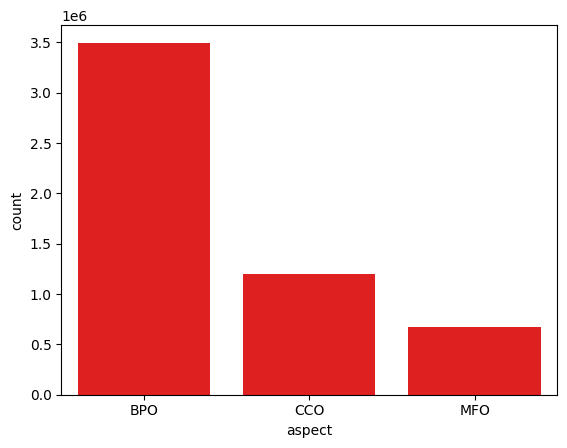

In [12]:
sns.countplot(data=reduce_mem_usage(get_dataframe(train_terms)),x='aspect',color='r')

In [13]:
train_terms=reduce_mem_usage(get_dataframe(train_terms))

Memory usage of dataframe is 122.77 MB
Memory usage after optimization is: 42.17 MB
Decreased by 65.6%


In [14]:
def get_train_dataset():
    train_protein_ids = np.load('/kaggle/input/t5embeds/train_ids.npy')
    train_embeddings = np.load('/kaggle/input/t5embeds/train_embeds.npy')
    column_num = train_embeddings.shape[1]
    train = pd.DataFrame(train_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
    return train,train_protein_ids

train,train_protein_ids = get_train_dataset()
print(train.shape,train_protein_ids.shape)

(142246, 1024) (142246,)


In [15]:
num_of_labels = 1500
def get_label_train_terms(df):
    labels=df['term'].value_counts().index[:num_of_labels].tolist()
    train_terms_updated=df.loc[df['term'].isin(labels)]
    return labels,train_terms_updated

labels_count,train_terms_updated=get_label_train_terms(train_terms)

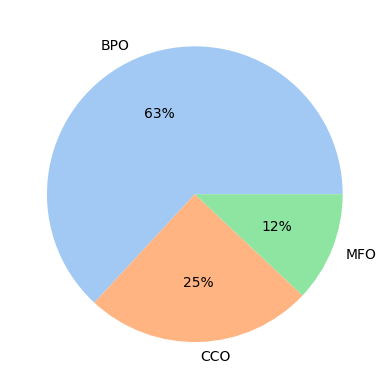

In [16]:
def show_pit_aspects():
    pie_df = train_terms_updated['aspect'].value_counts()
    palette_color = sns.color_palette('pastel')
    plt.pie(pie_df.values, labels=np.array(pie_df.index), colors=palette_color, autopct='%.0f%%')
    plt.show()
    
show_pit_aspects()

In [17]:
def get_labels(train_protein_ids):
    train_size = train_protein_ids.shape[0] # len(X)
    train_labels = np.zeros((train_size ,num_of_labels))
    series_train_protein_ids = pd.Series(train_protein_ids)

    for i in range(num_of_labels):
        n_train_terms = train_terms_updated[train_terms_updated['term'] ==  labels_count[i]]
        label_related_proteins = n_train_terms['EntryID'].unique()
        train_labels[:,i] =  series_train_protein_ids.isin(label_related_proteins).astype(float)
    return train_labels


train_labels=get_labels(train_protein_ids)

labels = pd.DataFrame(data = train_labels, columns = labels_count)
print(labels.shape)

(142246, 1500)


In [18]:
def train_test_dataset(features,labels):
    return  train_test_split(features,labels,shuffle=True,random_state=42)

X_train,X_val,y_train,y_val = train_test_dataset(train,labels)
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)



(106684, 1024) (35562, 1024) (106684, 1500) (35562, 1500)


In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [20]:
class FluxData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
            return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

X_data = torch.from_numpy(X_train.values).float().to(device)
y_data = torch.from_numpy(y_train.values).float().to(device)
X_val = torch.from_numpy(X_val.values).float().to(device)
y_val = torch.from_numpy(y_val.values).float().to(device)
train_data = FluxData(X_data,y_data)
test_data = FluxData(X_val,y_val)

In [21]:
class CAFA5NNetBase(torch.nn.Module):
    
    def training_step(self,batch):
        features,labels = batch
        out = self(features)
        loss = F.binary_cross_entropy(out,labels)
        return loss
    
    def validation_step(self, batch):
        features, labels = batch 
        out = self(features)                    # Generate predictions
        loss = F.binary_cross_entropy(out, labels)   # Calculate loss
        acc = auroc(out, labels)           # Calculate accuracy
        return {'Validation_loss': loss.detach(), 'Validation_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['Validation_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['Validation_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'Validation_loss': epoch_loss.item(), 'Validation_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        if epoch%5==0:
            print("Epoch [{}], Train_loss: {:.4f}, Validation_loss: {:.4f}, Validation_acc: {:.4f}".format(
            epoch, result['Train_loss'], result['Validation_loss'], result['Validation_acc']))

In [22]:
class CAFA5NNet(CAFA5NNetBase):
    def __init__(self,input_features,output_features):
        super(CAFA5NNet,self).__init__()
        self.network = torch.nn.Sequential(
        torch.nn.Linear(input_features,1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024,1024),    
        torch.nn.ReLU(),
        torch.nn.Linear(1024,output_features),
        torch.nn.Sigmoid()
        )
    def forward(self,inputs):
        return self.network(inputs)

In [23]:
model = CAFA5NNet(X_train.shape[1],y_train.shape[1])
model.to(device)

CAFA5NNet(
  (network): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1500, bias=True)
    (5): Sigmoid()
  )
)

In [24]:
torchsummary(model, X_data.size(), batch_size=-1, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1         [-1, 106684, 1024]       1,049,600
              ReLU-2         [-1, 106684, 1024]               0
            Linear-3         [-1, 106684, 1024]       1,049,600
              ReLU-4         [-1, 106684, 1024]               0
            Linear-5         [-1, 106684, 1500]       1,537,500
           Sigmoid-6         [-1, 106684, 1500]               0
Total params: 3,636,700
Trainable params: 3,636,700
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 416.73
Forward/backward pass size (MB): 5775.68
Params size (MB): 13.87
Estimated Total Size (MB): 6206.29
----------------------------------------------------------------


In [25]:
BATCH_SIZE = 5120
EPOCHS = 50
LEARNING_RATE = 0.001
MOMENTUM = 0.9
OPT_FUNC = torch.optim.Adam

In [26]:
def get_dataloaders(dataset_type,batch,shuffle):
    if shuffle:
         return DataLoader(dataset=dataset_type, batch_size=batch, shuffle=True)
    else:
        return DataLoader(dataset=dataset_type, batch_size=batch,shuffle=False)
    
train_dl = get_dataloaders(train_data,BATCH_SIZE,True)
val_dl = get_dataloaders(test_data,BATCH_SIZE,False)

In [27]:
def auroc(outputs, labels):
    auroc = AUROC(task="binary")
    return auroc(outputs, labels)

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = OPT_FUNC):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in tqdm(range(epochs)):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['Train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [28]:
history = fit(EPOCHS, LEARNING_RATE, model, train_dl, val_dl,OPT_FUNC)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [0], Train_loss: 0.2818, Validation_loss: 0.1227, Validation_acc: 0.8211
Epoch [5], Train_loss: 0.0760, Validation_loss: 0.0755, Validation_acc: 0.8548
Epoch [10], Train_loss: 0.0688, Validation_loss: 0.0683, Validation_acc: 0.9020
Epoch [15], Train_loss: 0.0646, Validation_loss: 0.0646, Validation_acc: 0.9198
Epoch [20], Train_loss: 0.0626, Validation_loss: 0.0630, Validation_acc: 0.9265
Epoch [25], Train_loss: 0.0611, Validation_loss: 0.0619, Validation_acc: 0.9304
Epoch [30], Train_loss: 0.0600, Validation_loss: 0.0611, Validation_acc: 0.9333
Epoch [35], Train_loss: 0.0588, Validation_loss: 0.0605, Validation_acc: 0.9354
Epoch [40], Train_loss: 0.0579, Validation_loss: 0.0599, Validation_acc: 0.9371
Epoch [45], Train_loss: 0.0570, Validation_loss: 0.0596, Validation_acc: 0.9381


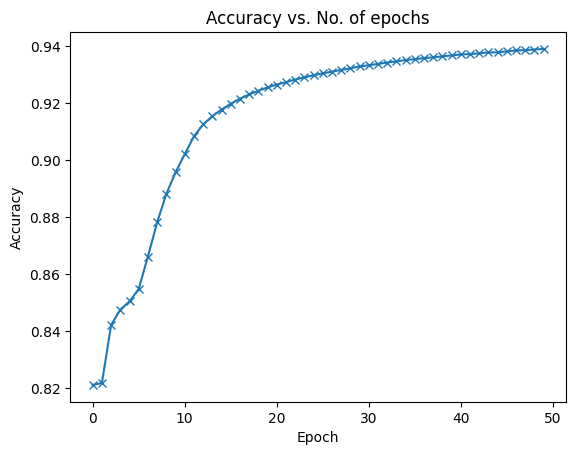

In [29]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['Validation_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)

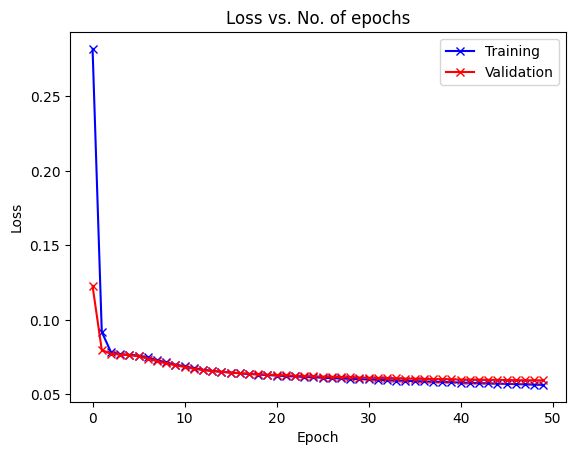

In [30]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('Train_loss') for x in history]
    val_losses = [x['Validation_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [31]:
def get_test_dataset():
    test_embeddings = np.load('/kaggle/input/t5embeds/test_embeds.npy')
    column_num = test_embeddings.shape[1]
    test = pd.DataFrame(test_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
    return test 

test = get_test_dataset()
print(test.shape)

(141865, 1024)


In [32]:
class CAFA5TestData(Dataset):
    
    def __init__(self, X_test_data):
        self.X_test_data = X_test_data
        
    def __getitem__(self, index):
        return self.X_test_data[index]
        
    def __len__ (self):
        return len(self.X_test_data)

In [33]:
test_data = CAFA5TestData(torch.from_numpy(test.values).float().to(device))
test_data_loader = DataLoader(dataset=test_data, batch_size=test.shape[0])


In [34]:

def eval_test_data(model,testing_data_dl):
    model.eval()
    with torch.no_grad():
        for X_batch_test in testing_data_dl:
            X_batch_test = X_batch_test.to(device)
            predictions = model(X_batch_test)
            prediction_target=predictions.detach().numpy()

    return prediction_target

prediction_target = eval_test_data(model,test_data_loader)

In [35]:
prediction_target.shape

(141865, 1500)

In [36]:
def make_predictions(prediction_target):
    test_protein_ids = np.load('/kaggle/input/t5embeds/test_ids.npy')
    protein_list = []
    for k in list(test_protein_ids):
        protein_list += [k] * prediction_target.shape[1] 
    return protein_list

protein_list=make_predictions(prediction_target)      

In [ ]:
def submit():
    df_submission = pd.DataFrame(columns = ['Protein Id', 'GO Term Id','Prediction'])
    df_submission['Protein Id'] = protein_list
    df_submission['GO Term Id'] = labels_count * prediction_target.shape[0]
    df_submission['Prediction'] = prediction_target.ravel()
    df_submission.to_csv("submission.tsv",header=False, index=False,sep='\t')
    
submit()

In [ ]:
temp=pd.read_csv('/kaggle/working/submission.tsv',sep='\t')
temp.count()